In [1]:
import sys

sys.path.append("/mnt/d/work/searchformer")

In [2]:
from copy import deepcopy
from searchformer.astar import (
    AStarState,
    TraceStep,
    CreateStep,
    CloseStep,
    AStarCannotSolveTaskException,
    PlanStep,
)
from typing import Optional, List, Dict, Sequence, Tuple
from dataclasses import dataclass
from heapq import heapify, heappop, heappush

In [3]:
def largest_contiguous_block_heuristic(state):
    target_peg=2
    total_disks=len(state[0]+state[1]+state[2])
    peg = state[target_peg]
    m = 0
    expected = total_disks
    for disk in peg:
        if disk == expected:
            m += 1
            expected -= 1
        else:
            break
    remaining = total_disks - m
    return 2 ** remaining - 1

In [4]:
def hanoi_tower_state_to_pretty_string(state: List[List[int]]) -> str:
    repr_str: str = ""
    for l1 in state:
        if len(l1) > 0:
            repr_str = repr_str + "-".join(str(x) for x in l1) + "."
        else:
            repr_str = repr_str + "."
    return repr_str[:-1]

In [5]:
hanoi_tower_state_to_pretty_string([[], [2, 3], []])

'.2-3.'

In [7]:
class HanoiTower:
    action_a_to_b: str = "a_to_b"
    action_a_to_c: str = "a_to_c"
    action_b_to_c: str = "b_to_c"
    action_b_to_a: str = "b_to_a"
    action_c_to_a: str = "c_to_a"
    action_c_to_b: str = "c_to_b"

    def __init__(
        self,
        peg_a: List[int] = [],
        peg_b: List[int] = [],
        peg_c: List[int] = [],
        num_disks: int = 3,
    ) -> None:
        self.peg_a: List = peg_a
        self.peg_b: List = peg_b
        self.peg_c: List = peg_c
        self.num_disks = num_disks

    @staticmethod
    def from_pegs(
        peg_a: List[int], peg_b: List[int], peg_c: List[int], num_disks=3
    ) -> "HanoiTower":
        return HanoiTower(
            peg_a=peg_a, peg_b=peg_b, peg_c=peg_c, num_disks=num_disks
        )

    def __hash__(self) -> int:
        states = map(
            lambda r: "".join(r),
            [
                [str(x) for x in self.peg_a],
                [str(x) for x in self.peg_b],
                [str(x) for x in self.peg_c],
            ],
        )
        return hash("-".join(states))

    def __repr__(self) -> str:
        return f"HanoiTower({self.peg_a},{self.peg_b},{self.peg_c})"

    def is_movable(self, from_peg: str, to_peg: str) -> bool:
        from_peg = getattr(self, f"peg_{from_peg}")
        to_peg = getattr(self, f"peg_{to_peg}")

        if len(from_peg) == 0:
            return False
        element1 = from_peg[-1]

        if len(to_peg) == 0:
            return True

        element2 = to_peg[-1]
        if element1 > element2:
            return False
        return True

    def heuristic(self):
        state = [self.peg_a, self.peg_b, self.peg_c]
        # goal = sorted(sum(state, []), reverse=True)
        # peg3 = state[2]
        # correct = 0
        # for i in range(min(len(peg3), len(goal))):
        #     if peg3[i] == goal[i]:
        #         correct += 1
        #     else:
        #         break
        # return len(goal) - correct
        return largest_contiguous_block_heuristic(state=state)

    def state(self) -> List[List[int]]:
        return deepcopy([self.peg_a, self.peg_b, self.peg_c])

    def _try_to_move(self, from_peg: str, to_peg: str) -> bool:
        return self.is_movable(from_peg=from_peg, to_peg=to_peg)

    def is_complete(self) -> bool:
        if len(self.peg_c) == self.num_disks:
            return True
        return False

    def move_a_to_b(self) -> bool:
        movable: bool = self.is_movable("a", "b")
        if movable:
            element: int = self.peg_a.pop()
            self.peg_b.append(element)
        return movable

    def move_a_to_c(self) -> bool:
        movable: bool = self.is_movable("a", "c")
        if movable:
            element: int = self.peg_a.pop()
            self.peg_c.append(element)
        return movable

    def move_b_to_a(self) -> bool:
        movable: bool = self.is_movable("b", "a")
        if movable:
            element: int = self.peg_b.pop()
            self.peg_a.append(element)
        return movable

    def move_b_to_c(self) -> bool:
        movable: bool = self.is_movable("b", "c")
        if movable:
            element: int = self.peg_b.pop()
            self.peg_c.append(element)
        return movable

    def move_c_to_a(self) -> bool:
        movable: bool = self.is_movable("c", "a")
        if movable:
            element: int = self.peg_c.pop()
            self.peg_a.append(element)
        return movable

    def move_c_to_b(self) -> bool:
        movable: bool = self.is_movable("c", "b")
        if movable:
            element: int = self.peg_c.pop()
            self.peg_b.append(element)
        return movable

    def move(self, action: str) -> None:
        if action == self.action_a_to_b:
            self.move_a_to_b()
        elif action == self.action_a_to_c:
            self.move_a_to_c()
        elif action == self.action_b_to_a:
            self.move_b_to_a()
        elif action == self.action_b_to_c:
            self.move_b_to_c()
        elif action == self.action_c_to_a:
            self.move_c_to_a()
        elif action == self.action_c_to_b:
            self.move_c_to_b()
        else:
            ValueError(f"invalid action : {action}")

In [8]:
move_str: str = """Move disk 1 from rod A to B
Move disk 2 from rod A to C
Move disk 1 from rod B to C
Move disk 3 from rod A to B
Move disk 1 from rod C to A
Move disk 2 from rod C to B
Move disk 1 from rod A to B
Move disk 4 from rod A to C
Move disk 1 from rod B to C
Move disk 2 from rod B to A
Move disk 1 from rod C to A
Move disk 3 from rod B to C
Move disk 1 from rod A to B
Move disk 2 from rod A to C
Move disk 1 from rod B to C"""

In [9]:
move_str: list[str] = move_str.split("\n")
moves: list[str] = [mv[-6:].lower().replace(" ", "_") for mv in move_str]

In [10]:
print(moves)

['a_to_b', 'a_to_c', 'b_to_c', 'a_to_b', 'c_to_a', 'c_to_b', 'a_to_b', 'a_to_c', 'b_to_c', 'b_to_a', 'c_to_a', 'b_to_c', 'a_to_b', 'a_to_c', 'b_to_c']


In [11]:
tower_of_hanoi: HanoiTower = HanoiTower([3, 2, 1], [], [])

In [12]:
mvs = ["a_to_c", "a_to_b", "c_to_b", "a_to_c", "b_to_a", "b_to_c", "a_to_c"]

In [13]:
print(tower_of_hanoi)
for mv in mvs:
    tower_of_hanoi.move(action=mv)
    print(tower_of_hanoi)
    # print(tower_of_hanoi.heuristic())

HanoiTower([3, 2, 1],[],[])
HanoiTower([3, 2],[],[1])
HanoiTower([3],[2],[1])
HanoiTower([3],[2, 1],[])
HanoiTower([],[2, 1],[3])
HanoiTower([1],[2],[3])
HanoiTower([1],[],[3, 2])
HanoiTower([],[],[3, 2, 1])


In [14]:
tower_of_hanoi.heuristic()

0

In [15]:
class TowerState(AStarState):
    def __init__(
        self,
        hanoi_tower: HanoiTower,
        cost_from_start: float = 0,
        path: str = "",
        parent: Optional["TowerState"] = None,
        deterministic: bool = True,
    ) -> None:
        super().__init__(parent, deterministic)
        self.hanoi_tower = hanoi_tower
        self._cost_from_start = cost_from_start
        self.path = path
        self.possible_moves = [
            "a_to_b",
            "a_to_c",
            "b_to_a",
            "b_to_c",
            "c_to_a",
            "c_to_b",
        ]

    @property
    def state(self) -> dict:
        return dict(state=self.hanoi_tower.state())

    def _construct_child(self, direction: str) -> "TowerState":
        hanoi_tower_child: HanoiTower = deepcopy(self.hanoi_tower)
        hanoi_tower_child.move(direction)
        return TowerState(
            hanoi_tower=hanoi_tower_child,
            cost_from_start=self.cost_from_start + 1,
            parent=self,
            path=self.path + "-" + direction,
        )

    def _get_children(self) -> list["TowerState"]:
        child_nodes: list[TowerState] = []
        for direction in self.possible_moves:
            pegs: list[str] = direction.split("_")
            is_movable: bool = self.hanoi_tower.is_movable(
                from_peg=pegs[0], to_peg=pegs[-1]
            )
            if is_movable:
                child_nodes.append(self._construct_child(direction=direction))
        return child_nodes

    @property
    def heuristic(self) -> float:
        return self.hanoi_tower.heuristic()

    @property
    def cost_from_start(self) -> float:
        return self._cost_from_start

    def __hash__(self) -> int:
        return hash(self.hanoi_tower)

    @property
    def is_goal(self) -> bool:
        return self.hanoi_tower.is_complete()

In [16]:
class StateManager:
    def __init__(self) -> None:
        self.state_dict = {}
        self.counter = 0

    def state_to_node_id(self, state) -> int:
        id = self.state_dict.get(state, None)
        if id is not None:
            self.state_dict.pop(state)
            self.state_dict[state] = id
            return id
        id = self.counter
        self.state_dict[state] = self.counter
        self.counter = self.counter + 1
        return id

    def node_id_to_state(self, node_id: int) -> TowerState:
        for k, v in self.state_dict.items():
            if v == node_id:
                return k
        return None

    def check_node_id(self, node) -> dict:
        out = {}
        for node in [node]:
            id = self.state_dict.get(node, None)
            out[node] = id
        return out

    def update_node_id(self, node, node_id):
        self.state_dict[node] = node_id

In [17]:
import math

In [18]:
def check_heap(pq, n):
    for el in pq:
        if hash(n) == hash(el[1]):
            return el
    return None


def a_star_simple(start_state: TowerState):
    id: int = 0
    messages: List[Dict] = []
    last = {}
    cost = {}
    state_manager = StateManager()
    graph = {}
    heap = []
    pq: List[Tuple[float, TowerState]] = []
    rep_start = hanoi_tower_state_to_pretty_string(start_state.state["state"])
    m0 = f"start state: {rep_start}\ncost: {start_state.cost}"
    messages.append({"role": "user", "content": m0})
    m1 = f"start state: {rep_start}\ncheck node id\nAction: check_node_id('{rep_start}')"
    messages.append({"role": "assistant", "content": m1})
    m2 = f"observation: {state_manager.check_node_id(rep_start)}"
    messages.append({"role": "user", "content": m2})
    m3: str = (
        f"Node does not exist yet assigning node id\nAction: update_node_id(node='{rep_start}',node_id={id})"
    )
    messages.append({"role": "assistant", "content": m3})
    state_manager.state_dict[rep_start] = id
    messages.append({"role": "user", "content": "observation: done"})
    graph[id] = []
    m4 = f"adding node to the graph \ngraph={graph}\npushing node to the heap with its heuristic\nAction: push_heap(cost={start_state.heuristic},node_id={id})"
    messages.append({"role": "assistant", "content": m4})
    heappush(pq, (start_state.heuristic, start_state))
    heappush(heap, (start_state.cost, id))
    m5 = "observation: done"
    messages.append({"role": "user", "content": m5})
    m6 = (
        f"updating cost of the state\nAction: update_cost(cost=0,node_id={id})"
    )
    messages.append({"role": "assistant", "content": m6})
    cost[rep_start] = 0
    m7 = "observation: done"
    messages.append({"role": "user", "content": m7})
    m8 = "initializing the search"
    messages.append({"role": "assistant", "content": m8})
    while len(pq) > 0:
        m9 = "selecting the lowest cost node from the heap"
        h, current = heappop(pq)
        rep_current = hanoi_tower_state_to_pretty_string(
            current.state["state"]
        )
        current_id = state_manager.state_dict[rep_current]
        heap.remove((h, current_id))
        m10 = "Action: pop_heap()"
        messages.append({"role": "assistant", "content": f"{m9}\n{m10}"})
        m11 = "observation: " + str({"node_id": current_id, "heuristic": h})
        messages.append({"role": "user", "content": m11})
        
        m11_=f"checking cost of the current node\nAction: check_cost(node_id={current_id})"
        messages.append({"role":"assistant","content":m11_})
        m11__=f"observation: {cost[rep_current]}"
        messages.append({"role":"user","content":m11__})
        m12 = f"check if the current node is goal node\nAction: check_goal(node_id={current_id})"
        messages.append({"role": "assistant", "content": m12})
        if current.is_goal:
            m13 = "observation: True"
            messages.append({"role": "user", "content": m13})
            m14 = "goal is reached exiting the search"
            messages.append({"role": "assistant", "content": m14})
            return last, messages
        else:
            m15 = "observation: False"
            messages.append({"role": "user", "content": m15})
            m16 = f"current node is not goal node so exploring its childs\nAction: get_childs(node_id={current_id})"
            messages.append({"role": "assistant", "content": m16})
            childs_rep = []
            for child in current.children:
                childs_rep.append(
                    hanoi_tower_state_to_pretty_string(child.state["state"])
                )
            m17 = f"observation: {childs_rep}"
            messages.append({"role": "user", "content": m17})

        for neighbor in current.children:

            rep_neighbor = hanoi_tower_state_to_pretty_string(
                neighbor.state["state"]
            )
            m18 = f"current child is {rep_neighbor}"
            m19 = f"checking node id\nAction: check_node_id('{rep_neighbor}')"
            messages.append({"role": "assistant", "content": m18 + "\n" + m19})
            child_id = state_manager.check_node_id(rep_neighbor)[rep_neighbor]
            # print(child_id)
            m20 = f"observation: {child_id}"
            messages.append({"role": "user", "content": m20})

            if child_id is not None:
                m21 = "child node already has an id so continuing"
                messages.append({"role": "assistant", "content": m21})
            else:
                id += 1
                m22 = f"child node does not have and id so assigning one\nAction: update_node_id(node='{rep_neighbor}',node_id={id})"
                messages.append({"role": "assistant", "content": m22})
                m23 = "observation: done"
                messages.append({"role": "user", "content": m23})
                state_manager.state_dict[rep_neighbor] = id
                child_id = id
            
            m24 = f"checking cost of the current child\nAction: check_cost(node_id={id})"
            messages.append({"role": "assistant", "content": m24})
            old_cost = cost.get(rep_neighbor, None)
            if old_cost is None:
                old_cost = math.inf
                cost[rep_neighbor] = math.inf
            m25 = f"observation: {old_cost}"
            messages.append({"role": "user", "content": m25})
            new_cost = cost[rep_current] + 1

            if cost[rep_neighbor] > cost[rep_current] + 1:
                m26 = f"new cost is the cost of the parent +1 which is new_cost={cost[rep_current]}+1={new_cost}\nsince new cost is less than the old cost\n{old_cost}>{new_cost}\nupdating the cost of the neighbour\nAction: update_cost(node_id={child_id},cost={new_cost})"
                messages.append({"role": "assistant", "content": m26})
                cost[rep_neighbor] = cost[rep_current] + 1
                m27 = "observation: done"
                messages.append({"role": "user", "content": m27})
                m28 = f"updating the parent of the child node\nAction: update_parent(child={child_id},parent={current_id})"
                messages.append({"role": "assistant", "content": m28})
                last[rep_neighbor] = rep_current
                m29 = "observation: done"
                messages.append({"role": "user", "content": m29})
                m30 = f"getting heuristic of the current child\nAction: get_heuristic(node_id={child_id})"
                messages.append({"role": "assistant", "content": m30})
                m31 = f"observation: {neighbor.heuristic}"
                messages.append({"role": "user", "content": m31})
                est_value: float = cost[rep_neighbor] + neighbor.heuristic
                m32 = f"calculating the estimated cost of the current child which is new cost plus the heuristic cost of the current child so estimated_cost={new_cost}+{neighbor.heuristic}={est_value}\nchecking whether the current child is already in heap\nAction: check_heap(node_id={child_id})"
                messages.append({"role": "assistant", "content": m32})
                is_neighbor_in_pq = check_heap(pq, neighbor)
                is_neighbor_in_heap = check_heap(heap, child_id)
                if is_neighbor_in_pq:
                    m33 = f"observation: {is_neighbor_in_heap}"
                    messages.append({"role": "user", "content": m33})
                    m34 = f"since the current child: {child_id} is in the heap with cost: {is_neighbor_in_heap[0]}. Removing it from the heap\nAction: remove_heap(cost={is_neighbor_in_heap[0]},node_id={child_id})"
                    messages.append({"role": "assistant", "content": m34})
                    pq.remove(is_neighbor_in_pq)
                    heap.remove(is_neighbor_in_heap)
                    m35 = "observation: done"
                    messages.append({"role": "user", "content": m35})
                    m36 = f"pushing the child node with new estimated cost in the heap\nAction: push_heap(cost={est_value},node_id={child_id})"
                    messages.append({"role": "assistant", "content": m36})
                    heappush(heap, (est_value, child_id))
                    heappush(pq, (est_value, neighbor))
                    m37 = "observation: done"
                    messages.append({"role": "user", "content": m37})
                else:
                    m38 = "observation: None"
                    messages.append({"role": "user", "content": m38})
                    m39 = f"since current child is not in the heap. So pushing it to the heap with the estimated cost\nAction: push_heap(cost={est_value},node_id={child_id})"
                    messages.append({"role": "assistant", "content": m39})
                    heappush(pq, (est_value, neighbor))
                    heappush(heap, (est_value, child_id))
                    m40 = "observation: done"
                    messages.append({"role": "user", "content": m40})
            else:
                m41 = f"new cost is the cost of the parent +1 which is new_cost={new_cost}\nsince new cost is greater than the old cost\n{old_cost}<{new_cost}\nso continuing"
                messages.append({"role": "assistant", "content": m41})
            if not graph.get(child_id):
                graph[child_id] = []

            if child_id not in graph[current_id]:
                graph[current_id].append(child_id)

            if current_id not in graph[child_id]:
                graph[child_id].append(current_id)
            messages.append(
                {"role": "assistant", "content": f"current graph is :{graph}"}
            )

    return last, messages

In [19]:
path, messages_ = a_star_simple(
    TowerState(HanoiTower(peg_a=[3, 2, 1], peg_b=[], peg_c=[], num_disks=3))
)

In [20]:
messages_

[{'role': 'user', 'content': 'start state: 3-2-1..\ncost: 7'},
 {'role': 'assistant',
  'content': "start state: 3-2-1..\ncheck node id\nAction: check_node_id('3-2-1..')"},
 {'role': 'user', 'content': "observation: {'3-2-1..': None}"},
 {'role': 'assistant',
  'content': "Node does not exist yet assigning node id\nAction: update_node_id(node='3-2-1..',node_id=0)"},
 {'role': 'user', 'content': 'observation: done'},
 {'role': 'assistant',
  'content': 'adding node to the graph \ngraph={0: []}\npushing node to the heap with its heuristic\nAction: push_heap(cost=7,node_id=0)'},
 {'role': 'user', 'content': 'observation: done'},
 {'role': 'assistant',
  'content': 'updating cost of the state\nAction: update_cost(cost=0,node_id=0)'},
 {'role': 'user', 'content': 'observation: done'},
 {'role': 'assistant', 'content': 'initializing the search'},
 {'role': 'assistant',
  'content': 'selecting the lowest cost node from the heap\nAction: pop_heap()'},
 {'role': 'user', 'content': "observation:

In [21]:
for message in messages_:
    print(message["content"])

start state: 3-2-1..
cost: 7
start state: 3-2-1..
check node id
Action: check_node_id('3-2-1..')
observation: {'3-2-1..': None}
Node does not exist yet assigning node id
Action: update_node_id(node='3-2-1..',node_id=0)
observation: done
adding node to the graph 
graph={0: []}
pushing node to the heap with its heuristic
Action: push_heap(cost=7,node_id=0)
observation: done
updating cost of the state
Action: update_cost(cost=0,node_id=0)
observation: done
initializing the search
selecting the lowest cost node from the heap
Action: pop_heap()
observation: {'node_id': 0, 'heuristic': 7}
checking cost of the current node
Action: check_cost(node_id=0)
observation: 0
check if the current node is goal node
Action: check_goal(node_id=0)
observation: False
current node is not goal node so exploring its childs
Action: get_childs(node_id=0)
observation: ['3-2.1.', '3-2..1']
current child is 3-2.1.
checking node id
Action: check_node_id('3-2.1.')
observation: None
child node does not have and id so

In [22]:
for k, v in path.items():
    print(k, v)

3-2.1. 3-2-1..
3-2..1 3-2-1..
3.2.1 3-2..1
3.1.2 3-2.1.
3-1..2 3.1.2
3..2-1 3.1.2
3-1.2. 3.2.1
3.2-1. 3.2.1
.2-1.3 3.2-1.
1.2.3 .2-1.3
.2.3-1 .2-1.3
2..3-1 .2.3-1
1..3-2 1.2.3
.1.3-2 1..3-2
..3-2-1 1..3-2


In [23]:
TowerState(
    HanoiTower(peg_a=[4, 3, 2, 1], peg_b=[], peg_c=[], num_disks=4)
).state

{'state': [[4, 3, 2, 1], [], []]}

In [24]:
last_state_hash = hanoi_tower_state_to_pretty_string(
    HanoiTower(peg_a=[], peg_b=[], peg_c=[4, 3, 2, 1]).state()
)
start_state_hash = hanoi_tower_state_to_pretty_string(
    HanoiTower(peg_c=[], peg_b=[], peg_a=[4, 3, 2, 1]).state()
)
print(last_state_hash)

..4-3-2-1


In [23]:
def get_path(parent_dict, start, goal):
    path = []
    current = goal

    while current is not None:
        path.append(current)
        if current == start:
            break
        current = parent_dict.get(current)

    if path[-1] != start:
        return None  # No valid path found

    return path[::-1]  # Reverse to get the correct order


path_list = get_path(
    path, start_state_hash, last_state_hash
)  # Output: ['A', 'B', 'C', 'D', 'E']

In [ ]:
def astar_verbose(start_state: AStarState) -> Tuple[Sequence[TraceStep], List]:
    """A* implementation used for generating execution trace datasets.

    The start state (or node) is provided as input and expanded until an
    optimal plan is found.

    Args:
        start_state (AStarState): Start state.

    Raises:
        AStarCannotSolveTaskException: If no feasible plan is found
            and the goal is not reached.

    Returns:
        Sequence[TraceStep]: Sequence of execution trace steps.
    """
    messages: List[Dict] = []
    state_manager = StateManager()
    open_heap: List[AStarState] = []
    open_heap2 = []
    open_dict: Dict[AStarState, AStarState] = {}
    open_dict2 = {}
    closed_dict: Dict[AStarState, AStarState] = {}
    closed_dict2 = {}
    log: List[TraceStep] = []
    m1 = "root state:"
    m2 = hanoi_tower_state_to_pretty_string(state=start_state.state["state"])
    node_id = state_manager.state_to_node_id(start_state)

    m3 = f"node_id: {node_id}"
    m4 = f"cost: {start_state.cost}"
    m5 = f"heap: {open_heap2}"
    messages.append(
        {"role": "user", "content": f"{m1}\n{m2}\n{m3}\n{m4}\n{m5}"}
    )
    print(f"{m1}\n{m2}\n{m3}\n{m4}\n{m5}")
    # print("open_dict:", open_dict2)
    # print("closed_dict:", closed_dict2)
    m6 = "currently min heap is empty. Pushing root state to the heap"
    m7 = f"Action: push_heap(cost={start_state.cost},node_id={node_id})"
    messages.append(
        {
            "role": "assistant",
            "content": f"{m1}\n{m2}\n{m3}\n{m4}\n{m5}\n{m6}\n{m7}",
        }
    )
    curr_node = start_state
    heappush(open_heap, curr_node)
    heappush(open_heap2, (curr_node.cost, node_id))
    open_dict[curr_node] = curr_node
    open_dict2[node_id] = curr_node.cost
    print(f"{m6}\n{m7}")
    m8 = "observation: done"
    messages.append({"role": "user", "content": m8})
    print(m8)
    m9 = f"Action: push_open(node_id={node_id})"
    messages.append({"role": "assistant", "content": m9})
    print(m9)
    m10 = "observation: done\ninitializing search"
    messages.append({"role": "user", "content": m10})
    print(m10)
    log.append(
        CreateStep(
            state=curr_node.state,
            cost_from_start=curr_node.cost_from_start,
            heuristic=curr_node.heuristic,
            path=curr_node.path,
        )
    )

    while len(open_heap) > 0:
        curr_node = heappop(open_heap)
        cost, node_id = heappop(open_heap2)
        m11 = f"selecting the node from the heap with lowest cost\nnode_id: {node_id}\ncost: {cost}"
        m12 = f"Action: pop_heap(node_id={node_id},cost={cost})"
        messages.append({"role": "assistant", "content": m11 + "\n" + m12})
        print(m11 + "\n" + m12)
        m13 = "observation: done"
        messages.append({"role": "user", "content": m13})
        print(m13)
        del open_dict[curr_node]
        del open_dict2[node_id]
        closed_dict[curr_node] = curr_node
        m14 = "pushing node to the closed list"
        m15 = f"Action: push_closed(node_id={node_id})"
        messages.append({"role": "assistant", "content": m14 + "\n" + m15})
        print(m14 + "\n" + m15)
        m16 = "observation: done"
        messages.append({"role": "user", "content": m16})
        print(m16)
        closed_dict2[node_id] = curr_node.cost
        log.append(
            CloseStep(
                state=curr_node.state,
                cost_from_start=curr_node.cost_from_start,
                heuristic=curr_node.heuristic,
                path=curr_node.path,
            )
        )
        if curr_node.cost == float("inf"):
            m17 = "current node cost is infinity"
            m18 = "no feasible plan found"
            messages.append({"role": "assistant", "content": f"{m17}\n{m18}"})
            print(f"{m17}\n{m18}")
            # pickle.dump(log, open("./log.pkl", "wb"))
            raise AStarCannotSolveTaskException(log)

        m19 = f"Action: check_goal(node_id={node_id})"
        print(m19)
        messages.append({"role": "assistant", "content": m19})
        if curr_node.is_goal:
            m20 = "observation: True"
            messages.append({"role": "user", "content": m20})
            print(m20)
            m21 = "current node is the goal"
            m22 = "goal reached"
            messages.append({"role": "assistant", "content": f"{m21}\n{m22}"})
            print(f"{m21}\n{m22}")
            break
        else:
            m23 = "observation: False"
            messages.append({"role": "user", "content": m23})
            print(m23)
        m24 = f"Action: get_childs(node_id={node_id})"
        print(m24)
        messages.append({"role": "assistant", "content": m24})
        child_nodes = curr_node.children
        childs_tuple = []
        for child in child_nodes:
            childs_tuple.append(
                (child.cost, state_manager.state_to_node_id(child))
            )
        m25 = f"observation: {childs_tuple}\nexploring the child nodes"
        messages.append({"role": "user", "content": m25})
        print(m25)
        for child_node in curr_node.children:
            m26 = "current child:"
            child_node_id = state_manager.state_to_node_id(child_node)
            m27 = f"node_id: {child_node_id}"
            m28 = f"cost: {child_node.cost}"
            m29 = "checks:"
            m30 = f"Action: check_open(node_id={child_node_id})"
            messages.append(
                {
                    "role": "assistant",
                    "content": f"{m26}\n{m27}\n{m28}\n{m29}\n{m30}",
                }
            )
            print(f"{m26}\n{m27}\n{m28}\n{m29}\n{m30}")
            if child_node in open_dict.keys():
                m31 = "observation: True"
                messages.append({"role": "assistant", "content": m31})
                print(m31)
                if open_dict[child_node].cost <= child_node.cost:
                    m32 = "the cost of the child in open_dict is less than the child itself so continuing."
                    messages.append({"role": "assistant", "content": m32})
                    print(m32)
                    continue
                else:
                    # This deletion is necessary because the hash is a function
                    # of the state, not the cost of the node. If there a lower
                    # cost value is computed for the same state, the following
                    # will prevent adding multiple nodes with the same state
                    # but different costs to the heap.
                    # print(
                    #     "child node is already in heap with more cost value. Removing it from the heap."
                    # )

                    m33 = "the cost of the child in open_dict is more than the child itself so removing it from the heap."
                    m34 = f"Action: pop_heap(node_id={child_node_id},cost={child_node.cost})"
                    messages.append(
                        {"role": "assistant", "content": f"{m33}\n{m34}"}
                    )
                    print(f"{m33}\n{m34}")

                    m35 = "observation: done"
                    messages.append({"role": "user", "content": m35})
                    print(m35)
                    open_heap.remove(child_node)
                    open_heap2.remove((child_node.cost, child_node_id))
                    heapify(open_heap)
                    heapify(open_heap2)
                    del open_dict[child_node]
                    del open_dict2[child_node_id]
            else:
                m36 = "observation: False"
                messages.append({"role": "user", "content": m36})
                print(m36)

            m37 = f"Action: check_closed(node_id={child_node_id})"
            print(m37)
            messages.append({"role": "assistant", "content": m37})
            if child_node in closed_dict.keys():
                m38 = "observation: True"
                print(m38)
                messages.append({"role": "user", "content": m38})
                if closed_dict[child_node].cost <= child_node.cost:

                    m39 = "the cost of the child in closed_dict is less than the child itself so continuing"
                    print(m39)
                    messages.append({"role": "assistant", "content": m39})
                    continue
            else:
                m40 = "observation: False"
                print(m40)
                messages.append({"role": "user", "content": m40})
            heappush(open_heap, child_node)
            heappush(open_heap2, (child_node.cost, child_node_id))
            m41 = "adding child node to the heap"
            m42 = f"Action: push_heap(node_id={child_node_id},cost={child_node.cost})"
            messages.append({"role": "assistant", "content": f"{m41}\n{m42}"})
            print(f"{m41}\n{m42}")
            open_dict[child_node] = child_node
            open_dict2[child_node_id] = child_node.cost
            log.append(
                CreateStep(
                    state=child_node.state,
                    cost_from_start=child_node.cost_from_start,
                    heuristic=child_node.heuristic,
                    path=child_node.path,
                )
            )
            m41 = f"heap: {open_heap2}"
            messages.append({"role": "user", "content": m41})

        # print("open_dict:", open_dict2)
        # print("closed_dict:", closed_dict2)
    if not curr_node.is_goal:

        m42 = "no feasible plan found"
        messages.append({"role": "assistant", "content": m42})
        # pickle.dump(log, open("./log.pkl", "wb"))
        raise AStarCannotSolveTaskException(log)

    path: List[AStarState] = [curr_node]
    node = curr_node.parent
    while node is not None:
        path.insert(0, node)
        node = node.parent
    for node in path:
        log.append(
            PlanStep(
                state=node.state,
                cost_from_start=node.cost_from_start,
                heuristic=node.heuristic,
                path=node.path,
            )
        )

    return log, messages

In [24]:
@dataclass
class HanoiTowerTrace:
    hanoi_tower_start: HanoiTower
    trace: Sequence[TraceStep]

    def __hash__(self) -> int:
        return hash(self.hanoi_tower_start)

    def to_dict(self) -> Dict:
        return dict(
            hanoi_tower_start=self.hanoi_tower_start.state(),
            trace=[step.to_dict() for step in self.trace],
        )

    @staticmethod
    def generate(
        peg_a: list[int],
        peg_b: list[int],
        peg_c: list[int],
        num_disks: int = 3,
    ) -> Tuple["HanoiTowerTrace", List[Dict]]:
        hanoi_tower_start = HanoiTower.from_pegs(
            peg_a, peg_b, peg_c, num_disks=num_disks
        )
        trace, messages = astar_verbose(TowerState(hanoi_tower_start))
        return (
            HanoiTowerTrace(hanoi_tower_start=hanoi_tower_start, trace=trace),
            messages,
        )

    @property
    def reasoning_trace(self) -> Sequence[TraceStep]:
        return [s for s in self.trace if s.action != "plan"]

    @property
    def plan(self) -> Sequence[TraceStep]:
        return [s for s in self.trace if s.action == "plan"]

In [25]:
hanoi_tower_trace, messages = HanoiTowerTrace.generate(
    [3, 2, 1], [], [], num_disks=3
)

NameError: name 'astar_verbose' is not defined

In [45]:
hanoi_tower_trace.to_dict()

{'hanoi_tower_start': [[3, 2, 1], [], []],
 'trace': [{'action': 'create',
   'state': {'state': [[3, 2, 1], [], []]},
   'cost_from_start': 0,
   'heuristic': 3,
   'path': ''},
  {'action': 'close',
   'state': {'state': [[3, 2, 1], [], []]},
   'cost_from_start': 0,
   'heuristic': 3,
   'path': ''},
  {'action': 'create',
   'state': {'state': [[3, 2], [1], []]},
   'cost_from_start': 1,
   'heuristic': 3,
   'path': '-a_to_b'},
  {'action': 'create',
   'state': {'state': [[3, 2], [], [1]]},
   'cost_from_start': 1,
   'heuristic': 3,
   'path': '-a_to_c'},
  {'action': 'close',
   'state': {'state': [[3, 2], [1], []]},
   'cost_from_start': 1,
   'heuristic': 3,
   'path': '-a_to_b'},
  {'action': 'create',
   'state': {'state': [[3], [1], [2]]},
   'cost_from_start': 2,
   'heuristic': 3,
   'path': '-a_to_b-a_to_c'},
  {'action': 'close',
   'state': {'state': [[3, 2], [], [1]]},
   'cost_from_start': 1,
   'heuristic': 3,
   'path': '-a_to_c'},
  {'action': 'create',
   'state

In [46]:
messages

[{'role': 'user',
  'content': 'root state:\n3-2-1..\nnode_id: 0\ncost: 3\nheap: []'},
 {'role': 'assistant',
  'content': 'root state:\n3-2-1..\nnode_id: 0\ncost: 3\nheap: []\ncurrently min heap is empty. Pushing root state to the heap\nAction: push_heap(cost=3,node_id=0)'},
 {'role': 'user', 'content': 'observation: done'},
 {'role': 'assistant', 'content': 'Action: push_open(node_id=0)'},
 {'role': 'user', 'content': 'observation: done\ninitializing search'},
 {'role': 'assistant',
  'content': 'selecting the node from the heap with lowest cost\nnode_id: 0\ncost: 3\nAction: pop_heap(node_id=0,cost=3)'},
 {'role': 'user', 'content': 'observation: done'},
 {'role': 'assistant',
  'content': 'pushing node to the closed list\nAction: push_closed(node_id=0)'},
 {'role': 'user', 'content': 'observation: done'},
 {'role': 'assistant', 'content': 'Action: check_goal(node_id=0)'},
 {'role': 'user', 'content': 'observation: False'},
 {'role': 'assistant', 'content': 'Action: get_childs(node_i

In [25]:
from openai import OpenAI
from typing import Optional, List
from dotenv import load_dotenv, find_dotenv
import os
import ast

In [26]:
load_dotenv(find_dotenv())

True

In [27]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [28]:
system_prompt = """Your task is to role-play a particular type of search algorithm.

To help you mimic this algorithm successfully, you will be provided few-shot examples. Study these examples carefully to learn how to mimic the algorithm successfully.
You must adhere to the reasoning style and choice of words in these few-shot examples. Do not use any new words that aren't present in the few-shot examples.

If at any point, you think that you have found the final solution (i.e., the search is over), call the trace_path function. if you fail to find the path return final_path=None Do not fail to do this.
"""

In [29]:
messages_.insert(0, {"role": "system", "content": system_prompt})

In [30]:
messages_

[{'role': 'system',
  'content': "Your task is to role-play a particular type of search algorithm.\n\nTo help you mimic this algorithm successfully, you will be provided few-shot examples. Study these examples carefully to learn how to mimic the algorithm successfully.\nYou must adhere to the reasoning style and choice of words in these few-shot examples. Do not use any new words that aren't present in the few-shot examples.\n\nIf at any point, you think that you have found the final solution (i.e., the search is over), call the trace_path function. if you fail to find the path return final_path=None Do not fail to do this.\n"},
 {'role': 'user', 'content': 'start state: 3-2-1..\ncost: 7'},
 {'role': 'assistant',
  'content': "start state: 3-2-1..\ncheck node id\nAction: check_node_id('3-2-1..')"},
 {'role': 'user', 'content': "observation: {'3-2-1..': None}"},
 {'role': 'assistant',
  'content': "Node does not exist yet assigning node id\nAction: update_node_id(node='3-2-1..',node_id=

In [31]:
def fix_messages(messages):
    result = []
    result.append(messages[0])
    for message in messages[1:]:
        if result[-1]["role"] == message["role"]:
            result[-1]["content"] = (
                result[-1]["content"] + "\n" + message["content"]
            )
        else:
            result.append(message)
    return result

In [32]:
message_ = fix_messages(messages_)

In [33]:
def pretty_string_to_hanoi_tower(pretty_string: str):
    pegs = pretty_string.split(".")
    peg_a = pegs[0].split("-")
    peg_b = pegs[1].split("-")
    peg_c = pegs[2].split("-")
    peg_a = [int(el) for el in peg_a if el.isdigit()]
    peg_b = [int(el) for el in peg_b if el.isdigit()]
    peg_c = [int(el) for el in peg_c if el.isdigit()]
    return peg_a, peg_b, peg_c

In [34]:
pretty_string_to_hanoi_tower("4-3-2.1.")

([4, 3, 2], [1], [])

In [35]:
class StateManager2:
    def __init__(self) -> None:
        self.state_dict = {}

    def check_node_id(self, node):
        out = {}
        id = self.state_dict.get(node, None)
        out[node] = id
        return out

    def update_node_id(self, node_id, node):
        self.state_dict[node] = node_id

    def get_key(self, node_id):
        for k, v in self.state_dict.items():
            if v == node_id:
                return k
        return None

    def get_state(self, node_id) -> TowerState:
        node_repr = self.get_key(node_id)
        pegs = pretty_string_to_hanoi_tower(node_repr)  # type:ignore
        total_disk = len(pegs[0] + pegs[1] + pegs[2])
        state = TowerState(HanoiTower(*pegs, num_disks=total_disk))
        return state

In [36]:
import copy

In [37]:
class FewShotAStarSearchReAct:
    def __init__(
        self,
        client: OpenAI,
        model: str,
        messages: List[dict],
        start_state: TowerState,
        stop_string: str = "\nObservation:",
    ):
        self.client = client
        self.model = model
        self.messages = copy.deepcopy(messages)
        self.state_manager = StateManager2()
        self.root_state = start_state
        self.messages.append(
            {
                "role": "user",
                "content": f"solve for this\nroot_state:\n{hanoi_tower_state_to_pretty_string(start_state.state['state'])}\ncost: {start_state.cost}",
            }
        )
        self.heap = []
        self.parent = {}
        self.cost = {}
        self.stop_string = stop_string
        self.available_actions = [
            "push_heap",
            "pop_heap",
            "remove_heap",
            "check_node_id",
            "update_node_id",
            "update_cost",
            "check_goal",
            "check_cost",
            "check_heap",
            "get_heuristic",
            "get_childs",
            "update_parent",
        ]

    def chat_completion(
        self,
        messages: List[dict],
        model: str,
        temperature: float = 0.2,
        max_tokens: int = 4096,
        **kwargs,
    ) -> str:
        response = self.client.chat.completions.create(  # type:ignore
            messages=messages,  # type:ignore
            model=model,
            temperature=temperature,
            max_tokens=max_tokens,
            stop=self.stop_string,
            **kwargs,
        )
        return response.choices[0].message.content

    def check_tool_call_string(self, tool_call_string: str):
        if any(
            action in tool_call_string for action in self.available_actions
        ):
            try:
                args_ = []
                kwargs_ = []
                tree = ast.parse(tool_call_string.strip(), mode="eval")

                if isinstance(tree.body, ast.Call):
                    func_name = ast.unparse(tree.body.func)

                    if func_name not in self.available_actions:
                        return (
                            False,
                            f"Function '{func_name}' not in available actions!",
                        )

                    # Positional arguments
                    for arg in tree.body.args:
                        arg_str = ast.unparse(arg)
                        if arg_str == "heap":
                            args_.append("self.open_list")
                        elif arg_str == "inf":
                            args_.append("float('inf')")
                        else:
                            args_.append(arg_str)

                    # Keyword arguments
                    for kw in tree.body.keywords:
                        kwarg_str = ast.unparse(kw.value)
                        if kwarg_str == "inf":
                            kwarg_str = "float('inf')"
                        kwargs_.append(f"{kw.arg}={kwarg_str}")

                    # Combine args and kwargs
                    all_args = args_ + kwargs_
                    return True, f"self.{func_name}({', '.join(all_args)})"

                else:
                    return False, "Not a valid function call."
            except Exception as e:
                return False, f"Parsing error: {e}"
        else:
            return False, "Invalid tool call string!"

    def check_node_id(self, node):
        return f"{self.state_manager.check_node_id(node=node)}"

    def update_node_id(self, node, node_id):
        self.state_manager.update_node_id(node=node, node_id=node_id)
        return "done"

    def push_heap(self, cost, node_id):
        heappush(self.heap, (cost, node_id))
        return "done"

    def pop_heap(self):
        cost, node_id = heappop(self.heap)
        return {"cost": cost, "node_id": node_id}

    def update_cost(self, node_id, cost):
        self.cost[node_id] = cost
        return "done"

    def check_goal(self, node_id):
        state = self.state_manager.get_state(node_id)
        return state.is_goal

    def remove_heap(self, node_id, cost):
        self.heap.remove((cost, node_id))
        return "done"

    def check_cost(self, node_id):
        cost = self.cost.get(node_id, "inf")
        return cost

    def update_parent(self, child, parent):
        self.parent[child] = parent
        return "done"

    def get_heuristic(self, node_id):
        state = self.state_manager.get_state(node_id)
        return state.heuristic

    def check_heap(self, node_id):
        for el in self.heap:
            if node_id == el[1]:
                return el
        return None

    def get_childs(self, node_id: int) -> str:
        state: TowerState = self.state_manager.get_state(node_id)
        childs_states = state.children
        childs = []
        for child_node in childs_states:
            childs.append(
                hanoi_tower_state_to_pretty_string(child_node.state["state"])
            )
        return f"{childs}"

    def react_loop(self, step_limit: Optional[int] = None):
        i = 0
        while True:
            if step_limit is not None and i >= step_limit:
                print("Step limit exceeded! Breaking the ReAct loop...")
                break
            completion = self.chat_completion(self.messages, model=self.model)
            print(completion)
            print("---")
            # result=None
            if "goal is reached" in completion:
                self.messages.append(
                    {"role": "assistant", "content": completion}
                )
                return (
                    completion.split("Final solution:-")[-1]
                    .split("\n\n")[0]
                    .strip()
                )
            else:  # A tool call was made.
                tool_call_string = completion.split("Action: ")[-1].strip()
                flag, tool_call_string = self.check_tool_call_string(
                    tool_call_string
                )
                # print(tool_call_string)
                if flag:
                    # print("tool_call_string: ", tool_call_string)
                    result = eval(tool_call_string)
                    print(result)
                    print("---")
                # else:
                #     raise AssertionError("Invalid tool call string!")
                completion += "\nObservation: "
                self.messages.append(
                    {"role": "assistant", "content": completion}
                )
                self.messages.append({"role": "user", "content": str(result)})
            i += 1

In [38]:
few_shot_a_star_search = FewShotAStarSearchReAct(
    client=client,
    model="gpt-4o-mini",
    messages=messages_,
    start_state=TowerState(
        HanoiTower(peg_a=[3,1,2], peg_b=[], peg_c=[], num_disks=3)
    ),
)  # type:ignore

In [39]:
few_shot_a_star_search.react_loop(step_limit=250)

start state: 3-1-2..
check node id
Action: check_node_id('3-1-2..')
---
{'3-1-2..': None}
---
child node does not have an id so assigning one
Action: update_node_id(node='3-1-2..',node_id=0)
---
done
---
adding node to the graph 
graph={0: []}
pushing node to the heap with its heuristic
Action: push_heap(cost=7,node_id=0)
---
done
---
updating cost of the state
Action: update_cost(cost=0,node_id=0)
---
done
---
initializing the search
selecting the lowest cost node from the heap
Action: pop_heap()
---
{'cost': 7, 'node_id': 0}
---
checking cost of the current node
Action: check_cost(node_id=0)
---
0
---
check if the current node is goal node
Action: check_goal(node_id=0)
---
False
---
current node is not goal node so exploring its childs
Action: get_childs(node_id=0)
---
['3-1.2.', '3-1..2']
---
current child is 3-1.2.
checking node id
Action: check_node_id('3-1.2.')
---
{'3-1.2.': None}
---
child node does not have an id so assigning one
Action: update_node_id(node='3-1.2.',node_id=1)

'goal is reached exiting the search'

In [40]:
few_shot_a_star_search.cost

{0: 0,
 1: 1,
 2: 1,
 3: 2,
 4: 2,
 5: 2,
 6: 2,
 7: 3,
 8: 4,
 9: 4,
 10: 5,
 11: 6,
 12: 6}

In [41]:
few_shot_a_star_search.parent

{1: 0, 2: 0, 3: 1, 4: 1, 5: 2, 6: 2, 7: 3, 8: 7, 9: 7, 10: 8, 11: 10, 12: 10}

In [42]:
few_shot_a_star_search.state_manager.state_dict

{'3-1-2..': 0,
 '3-1.2.': 1,
 '3-1..2': 2,
 '3.2-1.': 3,
 '3.2.1': 4,
 '3.1.2': 5,
 '3..2-1': 6,
 '.2-1.3': 7,
 '1.2.3': 8,
 '.2.3-1': 9,
 '1..3-2': 10,
 '.1.3-2': 11,
 '..3-2-1': 12}

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

In [53]:
def visualize_graph(adjacency_list):
    """
    Visualizes a graph given its adjacency list using NetworkX.
    
    :param adjacency_list: Dictionary representing the adjacency list of the graph
    """
    # Create a directed graph from adjacency list
    G = nx.Graph()  # Use nx.Graph() for an undirected graph

    # Add edges to the graph
    for node, neighbors in adjacency_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # Layout for better visualization
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=200, font_size=10)
    
    plt.title("Graph Visualization from Adjacency List")
    plt.show()

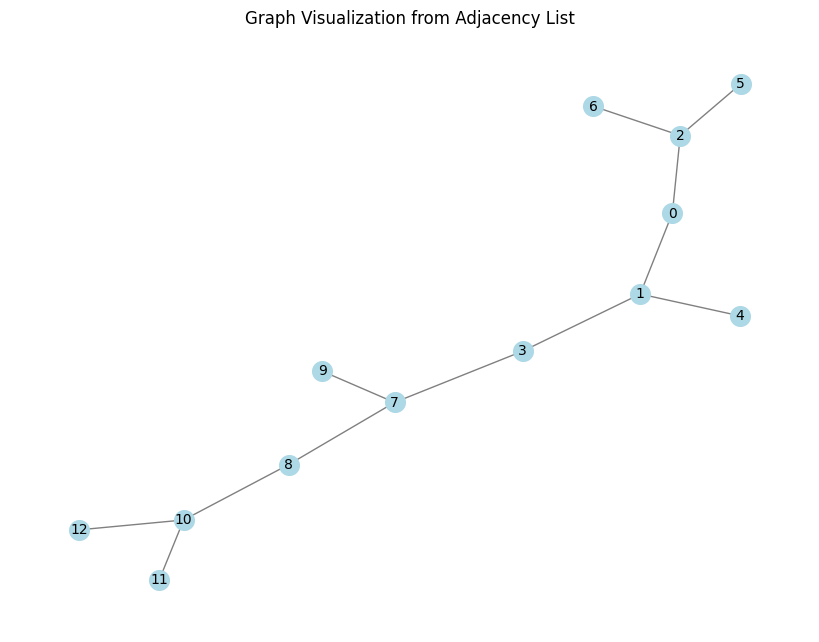

In [54]:
visualize_graph({0: [1, 2], 1: [0, 3, 4], 2: [0, 5, 6], 3: [1, 7], 4: [1], 5: [2], 6: [2], 7: [3, 8, 9], 8: [7, 10], 9: [7], 10: [8, 11, 12], 11: [10], 12: [10]})